In [1]:
import os
import ase
from ase.io import iread,write
import subprocess
import numpy as np
class lmf:
    def __init__(self,atoms=None,nkabc=[4,4,4],nkgw=[4,4,4],gw=1,ctrl="temp",gmax=10.5,p=5):
        self.nkabc=nkabc
        self.gmax=gmax
        self.nkgw=nkgw
        self.gw=gw
        self.ctrl=ctrl
        self.mpi_cmd="mpirun "
        self.atoms=atoms
        self.converged = False
        self.p=p
    # initialise mpi command
    def mpi(self,n=1): 
        return self.mpi_cmd+"-np "+str(n)
        
        
       # running shell commands
    def runcmd(self,exe,opt=""):    
        p = subprocess.Popen([exe, opt], stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
        out, err = p.communicate()
        return out.decode('utf-8'),err.decode('utf-8')   
        
        
        
        
        
        
       # blm module
    def blm(self):
        cmd = self.mpi()+" blm --express=0 --wsite --ctrl=ctrl --mol init."+self.ctrl
        cmd+=  " --nk="+str(self.nkabc).strip("][ ").replace(" ", "")
        cmd+= " --gmax="+str(self.gmax)
        if self.gw:
            if self.nkgw!=None: 
                cmd+=" --gw --nkgw="+str(self.nkgw).strip("][ ").replace(" ", "")
            else:print("please specify GW kpoinr mesh")

        return cmd
    def clean(self):
        out,err=self.runcmd("rm init 1 rst."+self.ctrl+" mixm."+self.ctrl+" wkp."+self.ctrl+" basp*"
                           +" atm."+self.ctrl+" save."+self.ctrl+" init."+self.ctrl)
        
    def write_infile(self,atoms):
        write(self.ctrl+".cif",atoms)
        out,err=self.runcmd(self.mpi()+" cif2cell "+self.ctrl+".cif >1")
        if err=='':out,err=self.runcmd(self.mpi()+" cif2init 1")
        if err=='':out,err=self.runcmd("cp init init."+self.ctrl)
        if err=='':out,err=self.runcmd(self.blm())
        
    def initialize(self,atoms):
        self.positions = atoms.get_positions().copy()
        self.numbers = atoms.get_atomic_numbers().copy()
        self.converged=False
        
        
    def calculate(self,atoms):
        self.positions = atoms.get_positions().copy()
        self.cell = atoms.get_cell().copy()
        self.pbc = atoms.get_pbc().copy()
        self.clean()
        self.write_infile(atoms)
        temp_cmd=self.mpi()+" lmfa ctrl."+self.ctrl
        print("running "+temp_cmd+"......")
        out,err=self.runcmd(temp_cmd)
        print("done\n")
        if err=='':
            temp_cmd="cp basp0."+self.ctrl+" basp."+self.ctrl
            print("running "+temp_cmd+"......")
            out,err=self.runcmd(temp_cmd)
            print("done\n")
        if err=='':
            temp_cmd=self.mpi(self.p)+" lmf -vnit=100 --wforce=force --wpos=pos "+self.ctrl+">output"
            print("running "+temp_cmd+"......")
            out,err=self.runcmd(temp_cmd)
            print("done\n")
        if err=='':
            f_read = open("save."+self.ctrl, "r")
            last_line = f_read.readlines()[-1][0]
            f_read.close()
            if last_line[0]=='c' or last_line[0]=='C':
                print("Calculation Converged")
                self.converged = True
                self.read_forces()     #read and add force variable
                self.read_potential()  #read and add potential variable
                self.read_efermi()     #read and add fermi variable
                
            else:
                print("Calculation NOT Converged")
                self.converged = False
                
           
    def update(self,atoms):
        if (not self.converged or
            len(self.numbers) != len(atoms) or
            (self.numbers != atoms.get_atomic_numbers()).any()):
            self.initialize(atoms)
            self.calculate(atoms)
            if self.converged==False:
                raise RuntimeError('Not yet converged')
        elif ((self.positions != atoms.get_positions()).any() or
              (self.pbc != atoms.get_pbc()).any() or
              (self.cell != atoms.get_cell()).any()):
                self.calculate(atoms)
                
                
    
    
    def get_potential_energy(self, atoms,force_consistent=False):
        self.update(atoms)
        return(self.etotal)
    
    
    def get_forces(self,atoms):
        self.update(atoms)
        return self.forces.copy()
    
    
    
                
    # Reading outputs
    def read_forces(self):
    
        lines = open("force."+self.ctrl, 'r').readlines()
        assert len(lines) == len(self.numbers) + 1
        lines = lines[1:]
        self.forces = np.zeros((len(lines), 3))
        for i in range(len(lines)):
            self.forces[i, 0] = float(lines[i].split()[0])
            self.forces[i, 1] = float(lines[i].split()[1])
            self.forces[i, 2] = float(lines[i].split()[2])
    def read_efermi(self):
        for i in open("output",'r'):
            if "Fermi" in i:
                self.e_fermi=float(i.split(";")[0].split(":")[-1])
    def read_potential(self):
        for i in open("save.temp",'r'):
            if "c" in i:
                self.etotal=float(i.split()[-1].split("=")[-1])

/home/srr70/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


running mpirun -np 1 lmfa ctrl.temp......
done

running cp basp0.temp basp.temp......
done

running mpirun -np 5 lmf -vnit=100 --wforce=force --wpos=pos temp>output......
done

Calculation Converged
running mpirun -np 1 lmfa ctrl.temp......
done

running cp basp0.temp basp.temp......
done

running mpirun -np 5 lmf -vnit=100 --wforce=force --wpos=pos temp>output......
done

Calculation Converged
running mpirun -np 1 lmfa ctrl.temp......
done

running cp basp0.temp basp.temp......
done

running mpirun -np 5 lmf -vnit=100 --wforce=force --wpos=pos temp>output......
done

Calculation Converged
running mpirun -np 1 lmfa ctrl.temp......
done

running cp basp0.temp basp.temp......
done

running mpirun -np 5 lmf -vnit=100 --wforce=force --wpos=pos temp>output......
done

Calculation Converged
running mpirun -np 1 lmfa ctrl.temp......
done

running cp basp0.temp basp.temp......
done

running mpirun -np 5 lmf -vnit=100 --wforce=force --wpos=pos temp>output......
done

Calculation Converged
(9.13

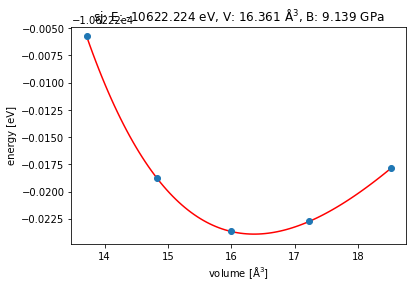

In [2]:
def test():
    import numpy as np
    from ase.io import read
    from ase.units import kJ
    from ase.eos import EquationOfState
    from ase import Atoms
    from ase.io.trajectory import Trajectory
    % matplotlib inline
    
    a = 4.0  # approximate lattice constant
    b = a / 2
    ag = Atoms('Ag',
               cell=[(0, b, b), (b, 0, b), (b, b, 0)],
               pbc=1,
               calculator=lmf())  # use EMT potential
    cell = ag.get_cell()
    traj = Trajectory('Ag.traj', 'w')
    for x in np.linspace(0.95, 1.05, 5):
        ag.set_cell(cell * x, scale_atoms=True)
        ag.get_potential_energy()
        traj.write(ag)
    

    configs = read('Ag.traj@0:5')  # read 5 configurations
    # Extract volumes and energies:
    volumes = [ag.get_volume() for ag in configs]
    energies = [ag.get_potential_energy() for ag in configs]
    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    print(B / kJ * 1.0e24, 'GPa')
    eos.plot('Ag-eos.png')


test()